Còdecs: blosclz i zstd

CONCLUSIONS: no es solapen

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import aux_funcs

## Collect data from 3 different containers

30: entropy bitshuffle (split)

0: blosclz bitshuffle split

1: zstd bitshuffle split

In [31]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-bitshuffle', 'blosclz-bitshuffle-split', 'zstd-bitshuffle-split']
categories = ["30", "0", "1"]

df_entropy = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_blosclz = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zstd = aux_funcs.get_df_by_category(paths, files[2], categories[2])

# Filter data

Delete data corresponding to special values chunks.

In [32]:
df_bitshuffle = pd.concat([df_blosclz, df_zstd, df_entropy], axis=1)
df_bitshuffle = aux_funcs.delete_special_vals(df_bitshuffle, ["special_vals0", "special_vals1", "special_vals30"])
df_input_x = df_bitshuffle.iloc[:, [6, 7]]

## Compute best category

In [33]:
df_codecs = df_bitshuffle.drop(['cratio30', 'speed30', 'special_vals30', 'special_vals0', 'special_vals1'], axis=1)

### Normalize cratio and speed

In [34]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
all_cratios = np.concatenate((ncratio0, ncratio1), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio

In [35]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3]], axis=0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
all_speeds = np.concatenate((nspeed0, nspeed1), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed

### Compute score to determine which category is the best one

In [36]:
theta_balance = 0.6

df_score_balance = pd.DataFrame()
df_score_balance.insert(0, 0, theta_balance*ncratio0 + (1-theta_balance)*nspeed0)
df_score_balance.insert(1, 1, theta_balance*ncratio1 + (1-theta_balance)*nspeed1)

In [37]:
best_categ_bitshuffle = pd.DataFrame(df_score_balance.idxmax(axis=1), columns=['best_categ'])

In [38]:
categories = best_categ_bitshuffle['best_categ'].unique()
if len(categories) < (len(files) - 1):
    raise ValueError("Not enough categories in training data")

In [39]:
df_t = pd.DataFrame()
df_t = pd.concat([df_t, df_input_x['cratio30']], axis=1)
df_t = pd.concat([df_t, df_input_x['speed30']], axis=1)
df_t = pd.concat([df_t, best_categ_bitshuffle], axis=1)

## Split data into training and test

Create a balanced training data with same amount of samples for each (best) category

In [40]:
df_blc = pd.DataFrame()
df_test = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]])) - 2000
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_blc = pd.concat([df_blc, df_i.head(n=nsamples)], axis=0)
    df_test = pd.concat([df_test, df_i.iloc[nsamples:, :]], axis=0)

In [41]:
dftrain_y = df_blc['best_categ']
dftrain_x = df_blc.drop(['best_categ'], axis=1)

In [42]:
dftest_y = df_test['best_categ']
dftest_x = df_test.drop(['best_categ'], axis=1)

## Normalize entropy data

In [43]:
dfcratios = dftrain_x.iloc[:, 0]
mean_cratio = dfcratios.mean()

cratio = dftrain_x["cratio30"]
cratio_mean = cratio.mean()
ncratio = cratio - cratio_mean
dsv_cratio = ncratio.std()
ncratio /= dsv_cratio

In [44]:
dfspeeds = dftrain_x.iloc[:, 1]
mean_speed = dfspeeds.mean()

speed = dftrain_x["speed30"]
speed_mean = speed.mean()
nspeed = speed - speed_mean
dvs_speed = nspeed.std()
nspeed /= dvs_speed

In [45]:
dftrain_x_norm = pd.DataFrame()
dftrain_x_norm.insert(0, "ncratio", ncratio)
dftrain_x_norm.insert(1, "nspeed", nspeed)
dftrain_x = dftrain_x_norm

# Normalize test data with train statistics
cratio_test = dftest_x["cratio30"]
speed_test = dftest_x["speed30"]
ncratio_test = cratio_test - cratio_mean
ncratio_test /= dsv_cratio
nspeed_test = speed_test - speed_mean
nspeed_test /= dvs_speed

dftest_x_norm = pd.DataFrame()
dftest_x_norm.insert(0, "ncratio", ncratio_test)
dftest_x_norm.insert(1, "nspeed", nspeed_test)

# Neural Network with 2 categories

## Build model

In [46]:
from keras.utils import to_categorical
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)

In [47]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [49]:
history = model.fit(dftrain_x, dftrain_y, epochs=20, validation_split=0.1)

Epoch 1/20
591/591 [==============================] - 2s 2ms/step - loss: 0.2029 - acc: 0.9712 - val_loss: 0.0746 - val_acc: 0.9871

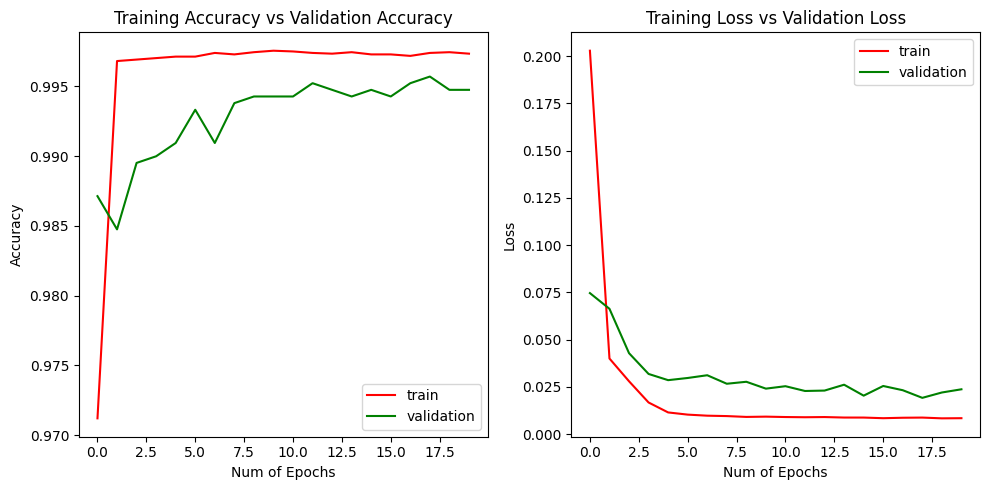

In [50]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch 5.

In [51]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=5, validation_split=0.1)

Epoch 1/5
591/591 [==============================] - 2s 2ms/step - loss: 0.1281 - acc: 0.9655 - val_loss: 0.0382 - val_acc: 0.9905

### Predict train data

In [52]:
y_hat = model.predict(x=dftrain_x)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(dftrain_y, axis=1)

656/656 [==============================] - 12s 16ms/step

In [54]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,10495,62
1,0,10433


In [55]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.9970462124821343

### Predict test data

In [56]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

2113/2113 [==============================] - 6s 3ms/step

In [57]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
1,65594,2000


In [58]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score_balance = (len(aux) - fails) / len(aux)
score_balance


0.029588425008136816